<a href="https://colab.research.google.com/github/Nourhan-Adell/Natural-language-processing/blob/main/Part_Of_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part of speech tagging**
Distinguishing the parts-of-speech of a word in a sentence will help you better understand the meaning of a sentence.

**Steps of POS:**
*   Learn how parts-of-speech tagging works
*    Compute the transition matrix A in a Hidden Markov Model.
*    Compute the emission matrix B in a Hidden Markov Model.
*    Compute the Viterbi algorithm.
*    Compute the accuracy of your own model.


## Preprocessing on the main text files to get the taged words

In [3]:
import nltk
nltk.download('gutenberg')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.corpus import gutenberg

corpus = gutenberg.raw('/content/hmm_vocab.txt')
tokenized = sent_tokenize(corpus)
for i in tokenized:
  words = nltk.word_tokenize(i)
  tagged_text = nltk.pos_tag(words)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## working with rtaining corpus:

In [4]:
# Load the training corpus

with open("/content/WSJ_02-21(1).pos", 'r') as file:
  training_corpus = file.readlines()

print(f'Few items of the training corpus list ')
print(training_corpus[0:5])

Few items of the training corpus list 
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [5]:
# read the vocabulary data, split by each line of text, and save the list
with open('/content/hmm_vocab.txt', 'r') as f:
  vocabulary = f.read().split('\n')
print(vocabulary[:5])

['!', '#', '$', '%', '&']


In [6]:
# vocab: dictionary that has the index of the corresponding words
vocab = {}
#get the index of the corresponding words
for i, word in enumerate(sorted(vocabulary)):
  vocab[word] = i


## Working with test data

In [7]:
# Load the test corpus
with open('/content/WSJ_24.pos', 'r')as file:
  testing_corpus = file.readlines()          #the testing_corpus

print(testing_corpus[0:5])

['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n']


In [8]:
#corpus without tags, preprocessed
from utils_pos import preprocess, get_word_tag
_, prep = preprocess(vocab, "/content/test.words")     

print('The length of the preprocessed test corpus: ', len(prep))
print('This is a sample of the test_corpus: ')
print(prep[0:10])

The length of the preprocessed test corpus:  34199
This is a sample of the test_corpus: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


# **Part 1: Parts-of-speech tagging**

## Part 1.1 - Training

You will start with the simplest possible parts-of-speech tagger and we will build up to the state of the art.

In this section, you will find the words that are not ambiguous

We need to compute:
1.    The transition_counts dictionary: which computes the number of times each tag happened next to another tag.
2.   The emission_counts:  will use it to compute the probability of a word given its tag. 
3.   The tag_counts:  the number of times each tag appeared.



In [9]:
import string
from collections import defaultdict

In [10]:
def create_dictionaries(training_corpus, vocab, verbose=True):
  # Intialize the dictionaries using defaultdict
  emission_counts = defaultdict(int)
  transition_counts = defaultdict(int)
  tag_counts = defaultdict(int)

  # Initialize the previous tag with the start state
  prev_tag = '--s--'
  # use i to track the line number in the corpus
  i=0

  for word_tag in training_corpus:
    i += 1
    word, tag = get_word_tag(word_tag, vocab)   # get the tag for each word from the vocabulary
    transition_counts[(prev_tag, tag)] += 1
    emission_counts[(tag, word)] += 1
    tag_counts[tag] += 1
    prev_tag = tag
  return emission_counts, transition_counts, tag_counts

In [11]:
import pandas as pd
def print_matrix(matrix):
    print(pd.DataFrame(matrix, index=sorted_tags, columns=sorted_tags))


In [12]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

In [13]:
# get all the POS states
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 46
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [14]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) 

transition examples: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission examples: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

ambiguous word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


## **Part 1.2 - Testing**

Now you will test the accuracy of your parts-of-speech tagger using your emission_counts dictionary. 

In [15]:
def predict_pos(prep, testing_corpus, emission_counts, vocab, state):
  # prep: is the preprocessed test corpus
  num_correct = 0
  all_words = set(emission_counts.keys())       # Get the (tag, word) tuples, stored as a set
  total_testwords = len(testing_corpus)
  for word, test_tuple in zip(prep, testing_corpus):
    # Split the (word, POS) string into a list of two items
    testing_tup1 = test_tuple.split()

    # Verify that y_tup contain both word and pos
    if len(testing_tup1) == 2:
      # Set the true POS label for this word
      true_label = testing_tup1[1]
    else:
      continue

    count_final = 0
    pos_final = 0

    if word in vocab:
      for pos in state:
        key = (pos, word)
        if key in emission_counts:
          # get the emission count of the (pos,word) tuple
          count = emission_counts[key]
          if count > count_final:
            count_final =count
            pos_final = pos

      if pos_final == true_label:
        num_correct += 1

  accuracy = num_correct / total_testwords
  return accuracy

In [16]:
accuracy_predict_pos = predict_pos(prep, testing_corpus, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.8889


# **Part 2.1 Generating Matrices**
## **Creating the 'A' transition probabilities matrix:**

Now that you have your emission_counts, transition_counts, and tag_counts, you will start implementing the Hidden Markov Model.

This will allow you to quickly construct the
*    A transition probabilities matrix.
*    and the B emission probabilities matrix.

You will also use some smoothing when computing these matrices

In [17]:
import numpy as np

def create_transition_matrix(alpha, tag_counts, transition_counts):
  #alpha: number used for smoothing
  all_tags = sorted(tag_counts.keys())  #get a sorted list of unique POs tags
  num_tags = len(all_tags)              #count the number of unique POStags

  # Intialize the transition matrix A
  A = np.zeros((num_tags, num_tags))

  # Get the unique transition tuples (previous POS, current POS)
  trans_keys = set(transition_counts.keys())

  for i in range(num_tags):
    for j in range(num_tags):
      count = 0
      key = (all_tags[i], all_tags[j])
      if key in transition_counts:
        count = transition_counts[key]  #Nomenator
      
      count_prev_tag = tag_counts[key[0]]    # Domenator
      A[i,j] = (count + alpha) / (count_prev_tag + alpha*num_tags)
  
  return A

In [18]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)
# Testing your function
print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


## **Create the 'B' emission probabilities matrix:**

In [19]:
def create_emission_matrix(alpha, states, tag_counts, emission_counts, vocab):
  num_tags = len(tag_counts)
  all_tags = states
  num_words = len(vocab)

  B = np.zeros((num_tags, num_words))
  emis_keys = set(list(emission_counts.keys()))
  for i in range(num_tags):
    for j in range(num_words):
      count = emission_counts[(all_tags[i], vocab[j])]
      count_prev_tag = tag_counts[all_tags[i]]
      B[i,j] = (count + alpha) / (count_prev_tag + (alpha * num_words))
  return B

In [20]:
# creating your emission probability matrix. this takes a few minutes to run. 
alpha = 0.001
B = create_emission_matrix(alpha, states, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


# **Implementing the Viterbi algorithm on a small data:**

In [35]:
states =  ('DT', "NN", 'VB')
observations = ('the', 'fans', 'watch', 'the', 'race')
start_probability = {'DT': 0.8, 'NN': 0.2, 'VB':0}
transition_probability = {'DT':{'DT':0, 'NN':0.9, 'VB':0.1},
                          'NN': {'DT': 0, 'NN':0.5, 'VB':0.5},
                          'VB':{'DT': 0.5, 'NN': 0.5, 'VB':0},}
emission_probability = {'DT':{'the':0.2, 'fans': 0,'watch':0, 'race':0},
                        'NN':{'the':0, 'fans': 0.1,'watch':0.3, 'race':0.1},
                        'VB':{'the':0, 'fans': 0.2,'watch':0.15, 'race':0.3}}

In [36]:
def viterbi_algorithm(obs, states, start_prob, transition_prob, emission_prob):
  path = {s:[] for s in states}
  current_prob = {}
  for s in states:
    current_prob[s] = start_prob[s] * emission_prob[s][obs[0]] 
  
  for i in range(1,len(obs)):
    last_prob = current_prob
    current_prob = {}
    for current_state in states:
      max_prob, last_state = max(((last_prob[last_state]*transition_prob[last_state][current_state]*emission_prob[current_state][obs[i]], last_state) 
				                       for last_state in states))
      current_prob[current_state] = max_prob
      path[current_state].append(last_state)
  
  # find the final largest probability
  max_prob = -1
  max_path = None
  for s in states:
    path[s].append(s)
    if current_prob[s] > max_prob:
      max_path = path[s]
      max_prob = current_prob[s]

  return max_path

In [37]:
if __name__ == '__main__':
	obs = ['normal', 'cold', 'dizzy']
	print(viterbi_algorithm(observations, states, start_probability, transition_probability, emission_probability))

['DT', 'NN', 'VB', 'DT', 'NN']


## **And this is illustrated as following pictures**

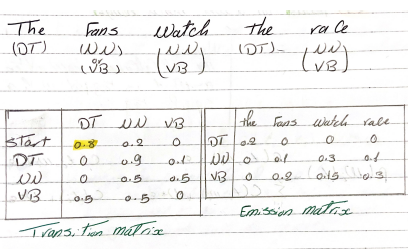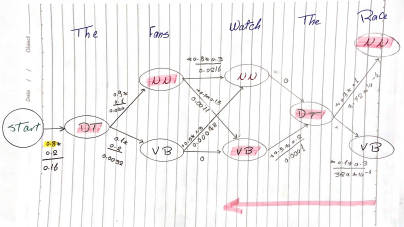